In this lab, we will go through the different aspects of common deep learning based problems, i.e. dealing with low dataset via transfer learning, class imbalance problem, overfitting and lastly hyperparameter optimisation

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(dpi=150)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [23]:
# importing and preparing the dataset
!wget --load-cookies /tmp/data_lab.zip "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/data_lab.zip --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1" -O data_lab.zip && rm -rf /tmp/data_lab.zip

print('Unzipping folder... this may take a few minutes without output. Be patient.')
with zipfile.ZipFile('data_lab.zip', 'r') as zip_ref:
    zip_ref.extractall('data_lab')

path_data = '/content/data_lab/data_lab'
train_dir = os.path.join(path_data, 'train')
validation_dir = os.path.join(path_data, 'valid')
test_dir = os.path.join(path_data, 'test')
print('Directories in unzipped folder:', os.listdir(path_data))


train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=16,
                                             image_size=(598, 598))

class_names = train_dataset.class_names

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=16,
                                                  image_size=(598, 598))

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=16,
                                            image_size=(598, 598))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

--2023-11-15 21:18:13--  https://docs.google.com/uc?export=download&confirm=t&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1
Resolving docs.google.com (docs.google.com)... 108.177.112.101, 108.177.112.102, 108.177.112.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.112.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f944bui3t8madkrfo7o7kfbgi4qoga9e/1700083050000/13525664275705142765/*/1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1?e=download&uuid=bf369d49-46a6-4b53-9455-8abf170a9171 [following]
--2023-11-15 21:18:13--  https://doc-04-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f944bui3t8madkrfo7o7kfbgi4qoga9e/1700083050000/13525664275705142765/*/1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1?e=download&uuid=bf369d49-46a6-4b53-9455-8abf170a9171
Resolving doc-04-48-docs.googleusercontent.com (doc-04-48-docs.googleusercontent.com)... 74.125.201.1

In [4]:
# class labels name
print(class_names)


['high', 'low']


In [ ]:
# Create the base model from the pre-trained model or with randomly initialised weights in MobileNet V2 architecture
transfer_learning = False
if transfer_learning:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                               include_top=False,
                                               weights='imagenet')

else:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                                 include_top=False,
                                                 weights=None)

base_model.trainable = True

inputs = tf.keras.Input(shape=(598, 598, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune only last 20% of layers
fine_tune_at = int(0.8*len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

learning_rate = 0.000001

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()
history = model.fit(train_dataset,
                    steps_per_epoch=25,
                    validation_steps=25,
                    epochs=10,
                    validation_data=validation_dataset)

plot_history(history)

You can observe the model did not learn anything with random initalisation of the weights. A lot of data is required to fine tune the millions of parameters (Note: here we only fine tune the last 20% of the layers of the network so we did not optimise anything in the 80% of the network).

Try running the model fitting with transfer learning where the pretrained model fitted on the Imagenet dataset is used to fine tune on the pathology images (same as the lab 1)

9406464/9406464 [==============================] - 0s 0us/step
Number of layers in the base model:  154
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 598, 598, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 598, 598, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 598, 598, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 global_average_pooli

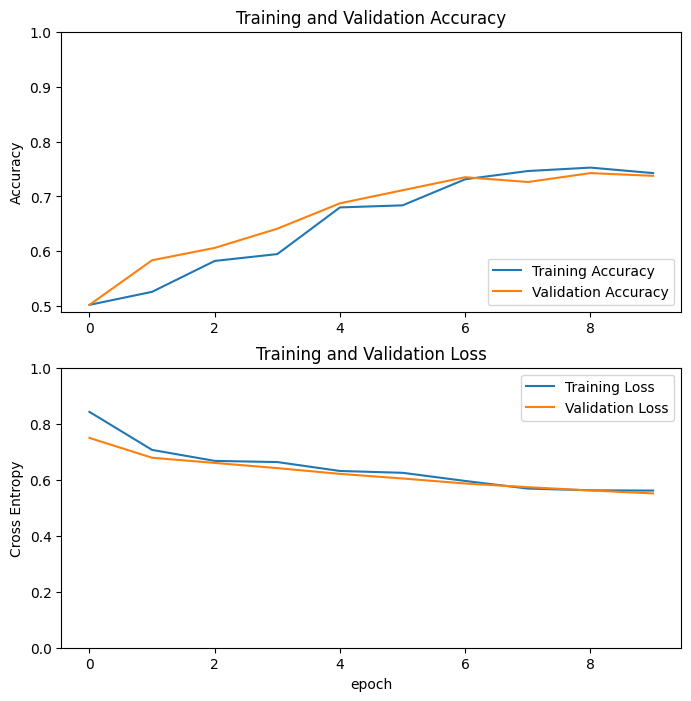

In [8]:
# Create the base model from the pre-trained model or with randomly initialised weights in MobileNet V2 architecture
transfer_learning = True

if transfer_learning:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                               include_top=False,
                                               weights='imagenet')

else:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                                 include_top=False,
                                                 weights=None)

base_model.trainable = True

inputs = tf.keras.Input(shape=(598, 598, 3))

x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune only last 20% of layers
fine_tune_at = int(0.8*len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

learning_rate = 0.000001

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

history = model.fit(train_dataset,
                    steps_per_epoch=25,
                    validation_steps=25,
                    epochs=10,
                    validation_data=validation_dataset)

plot_history(history)

What changes did you observe in the model learning curves?

Next we will include and observe the model overfitting and common strategies to deal with it.
Strategies: including the data augmentation in the input, the dropout layer in the base model and the early stopping callback in the model training

In [ ]:
# reducing the training dataset by a huge margin to introduce the overfitting
train_dataset_subset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(598, 598),
                                             validation_split = 0.97,
                                             seed = 523,
                                             subset = 'training')
train_dataset_subset = train_dataset_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
# Create the base model from the pre-trained model or with randomly initialised weights in MobileNet V2 architecture
tranfer_learning = True

if transfer_learning:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                               include_top=False,
                                               weights='imagenet')

else:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                                 include_top=False,
                                                 weights=None)

base_model.trainable = True

inputs = tf.keras.Input(shape=(598, 598, 3))

x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune only last 20% of layers
fine_tune_at = int(0.8*len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

learning_rate = 0.000001

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

history = model.fit(train_dataset_subset,
                    steps_per_epoch=25,
                    validation_steps=25,
                    epochs=50,
                    validation_data=validation_dataset)
plot_history(history)

Introducing the strategies to deal with overfitting

Found 10927 files belonging to 2 classes.
Using 328 files for training.


Number of layers in the base model:  154
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 598, 598, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 598, 598, 3)       0         
                                                                 
 tf.math.truediv_14 (TFOpLa  (None, 598, 598, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_14 (TFOpL  (None, 598, 598, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                 

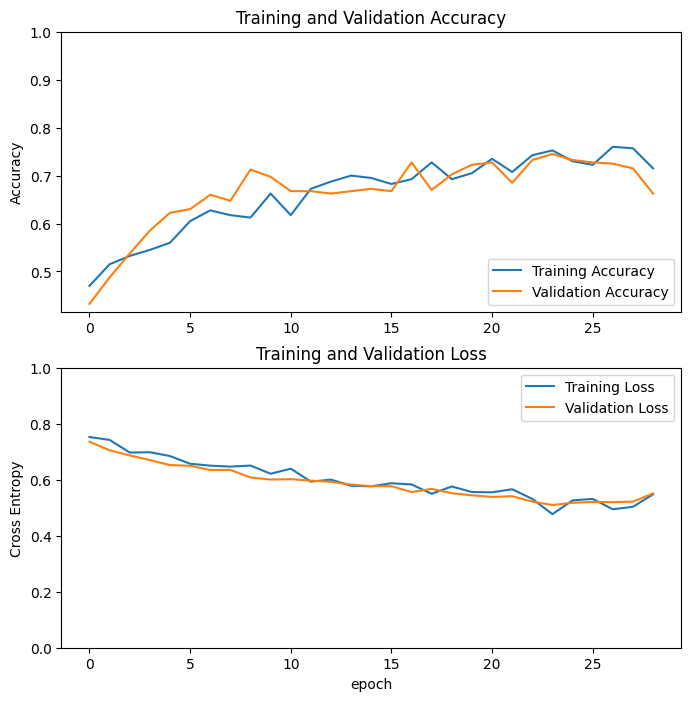

In [30]:
train_dataset_subset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(598, 598),
                                             validation_split = 0.97,
                                             seed = 523,
                                             subset = 'training')
train_dataset_subset = train_dataset_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()

# defining data augmentation, potentially can add more different ones
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create the base model from the pre-trained model or with randomly initialised weights in MobileNet V2 architecture
tranfer_learning = True
if tranfer_learning:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                               include_top=False,
                                               weights='imagenet')

else:
  base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                                 include_top=False,
                                                 weights=None)

base_model.trainable = True

inputs = tf.keras.Input(shape=(598, 598, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

## include the dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune only last 20% of layers
fine_tune_at = int(0.8*len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

learning_rate = 0.000001

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()
# introducing callbacks and earlystopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_dataset,
                    steps_per_epoch=25,
                    validation_steps=25,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=[callback],
                    verbose=1)

plot_history(history)

Here, you can observe the training stopped early due to earlystopping callback criteria which avoided the overfitting as we observed in the previous model learning curves.
If time allows you can apply the strategies one by one to see their effect on the model learning curves individually. You can try different parameters for dropout layer (dropout rate), early stopping (different evaluation metric to monitor, patience value etc.)

Last part of the lab includes the optimisation of the hyperparameter: learning rate

In [ ]:
## creating a grid of learning rates
learning_rates = [0.000001, 0.00001, 0.0001]
for learning_rate in list_of_learning_rates:

  loss = tf.keras.losses.BinaryCrossentropy()
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
  model.summary()
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  history = model.fit(train_dataset,
                      steps_per_epoch=10,
                      validation_steps=5,
                      epochs=10,
                      validation_data=validation_dataset,
                      callbacks=[callback],
                      verbose=1)
  plot_history(history)




You will have to wait for the three models to finish training. This might take few minutes.

What do you think is the optimum choice for the learning based on the model learning curves?

In [ ]:
## looking at the number of images from each class in the training data
print('Number of samples with gleason grade high: {}'.format(len(os.listdir('/content/data_lab/data_lab/train/high/'))))
print('Number of samples with gleason grade low: {}'.format(len(os.listdir('/content/data_lab/data_lab/train/low/'))))
# applying class weights during model training
neg = len(os.listdir('/content/data_lab/data_lab/train/low/'))
pos = len(os.listdir('/content/data_lab/data_lab/train/high/'))
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class low: {:.2f}'.format(weight_for_0))
print('Weight for class high: {:.2f}'.format(weight_for_1))

We will introduce class weights during the model training so the it takes into account the ratio of class imbalance while calculating the evaluation metric (i.e. loss) during the model training

In [ ]:
history = model.fit(train_dataset,
                    steps_per_epoch=25,
                    validation_steps=25,
                    epochs=10,
                    validation_data=validation_dataset,
                    class_weight=class_weight)

plot_history(history)